# CS3802--Machine Learning Algorithms Lab

Adithya V |
BTech CSE (IoT) - A | 21011102009

## Exercise 2
---
### a) Use the house_pred.csv file to build a multiple linear regression model. sklearn shall be used to fit the model. Perform necessary preprocessing and check for outliers and multi-collinearity. Apply the same set of preprocessing to the test.csv and use the data to predict the house price. The evaluation criteria will be Root Mean Squared Error

### Importing the necessary libraries 

In [34]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import math

### Reading the dataset

In [5]:
data = pd.read_csv('house_pred.csv')
data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

###  Pre-Processing 

##### Remove outliers using IQR method

The `IQR_Removal` function takes a DataFrame (`df`) as input and performs the following steps:

1. **Initialization:**
   - Retrieves column names from the DataFrame (`columns = df.columns`).

2. **Iterate Through Columns:**
   - For each column (`col`) in the DataFrame:
      - Skips the 'SalePrice' column.

3. **Check Column Type:**
   - Verifies if the column is not of type 'object' (i.e., numerical).

4. **Remove Outliers Using IQR:**
   - Calculates the first quartile (Q1), third quartile (Q3), and Interquartile Range (IQR) for the numerical column.
   - Filters rows to keep only those within the range of `(Q1 - 1.5 * IQR)` to `(Q3 + 1.5 * IQR)`.

5. **Return Updated DataFrame:**
   - Returns the DataFrame with outliers removed from numerical columns.

In [ ]:
def IQR_Removal(df):
    
    columns = df.columns
    for col in columns:
        if col == 'SalePrice':
            continue
        typeCol = str(df[col].dtype)
        if typeCol != 'object':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            iqr = Q3 - Q1
            df = df[(df[col] >= Q1 - 1.5*iqr) & (df[col] <= Q3 + 1.5*iqr)]
    return df

#### Remove columns with only one unique value and columns with null ratio >= 0.30

The `ThresholdandND_columnRemoval` function takes a DataFrame (`df`) as input and performs the following steps:

1. **Calculate Length and Columns:**
   - Retrieves the length of the DataFrame (`N = len(df)`) and column names (`columns = df.columns`).

2. **Iterate Through Columns:**
   - For each column (`col`) in the DataFrame:
      - Checks if the number of unique values in the column is equal to 1. If true, drops the column as it lacks diversity.

3. **Check Null Ratio:**
   - Calculates the ratio of null values in the column (`notnull = df[col].isnull().sum()`) and checks if it is greater than or equal to 30%.
   - If true, drops the column as it exceeds the specified null ratio threshold.

4. **Return Updated DataFrame:**
   - Returns the DataFrame with columns removed based on the threshold and no-diversity criteria.


In [30]:
def ThresholdandND_columnRemoval(df):
    
    N = len(df)
    columns = df.columns
    for col in columns:
        if (len(df[col].unique()) == 1):
            df = df.drop([col], axis=1)
            continue
        notnull = df[col].isnull().sum()
        ratio = notnull / N
        if (ratio >= 0.30):
            df = df.drop([col], axis=1)
    return df


#### Handle null values by either removing rows or filling with mean/median

The `Handling_NullValues` function takes a DataFrame (`df`) as input and performs the following steps:

1. **Iterate Through Columns:**
   - For each column (`col`) in the DataFrame:
      - Checks the data type of the column (`typeCol = str(df[col].dtype)`).

2. **Handle Null Values for Object Type:**
   - If the column type is 'object' (categorical):
      - Removes rows with null values for that column (`df = df[df[col].notna()]`).

3. **Handle Null Values for Numeric Type:**
   - If the column type is numeric:
      - Calculates mean, median, and standard deviation of the column (`mean = df[col].mean()`, `median = df[col].median()`, `standard_deviation = df[col].std()`).

4. **Partial Median Change (PMC) Criteria:**
   - Calculates Partial Median Change (PMC) using the formula `pmc = (3 * (mean - median)) / standard_deviation`.
   - If PMC is greater than or equal to 0.4 or less than or equal to -0.4:
      - Fills null values with the median (`df[col] = df[col].fillna(median)`).
   - Otherwise:
      - Fills null values with the mean (`df[col] = df[col].fillna(mean)`).

5. **Return Updated DataFrame:**
   - Returns the DataFrame with missing values handled based on data type and PMC criteria.



In [29]:
def Handling_NullValues(df):
   
    columns = df.columns
    for col in columns:
        typeCol = str(df[col].dtype)
        if typeCol == 'object':
            df = df[df[col].notna()]
        else:
            mean = df[col].mean()
            median = df[col].median()
            standard_deviation = df[col].std()
            pmc = (3 * (mean - median)) / standard_deviation
            if pmc >= 0.4 or pmc <= -0.4:
                df[col] = df[col].fillna(median)
            else:
                df[col] = df[col].fillna(mean)
    return df

#### Perform one-hot encoding for categorical columns

The `OneHotEncoding_objects` function encodes categorical (object-type) columns using one-hot encoding:

1. **Iterate Through Columns:**
   - For each column (`col`) in the DataFrame:
      - Check if the column type is 'object'.

2. **One-Hot Encode Object Columns:**
   - If the column is 'object':
      - Use `pd.get_dummies` to create one-hot encoded columns.

3. **Rename and Join Encoded Columns:**
   - Rename the new columns by appending the original column name as a prefix.
   - Join the one-hot encoded columns to the original DataFrame.

4. **Drop Original Object Column:**
   - Drop the original object-type column.

5. **Return Updated DataFrame:**
   - Returns the DataFrame with one-hot encoded object-type columns.

In [27]:
def OneHotEncoding_objects(df):
   
    columns = df.columns
    for col in columns:
        typeCol = str(df[col].dtype)
        if typeCol == 'object':
            enc = pd.get_dummies(df[col])
            encCol = enc.columns
            newColumns = {}
            for i in range(0, len(encCol)):
                newColumns[encCol[i]] = col + encCol[i]
            enc.rename(columns=newColumns, inplace=True)
            df = df.join(enc)
            df = df.drop([col], axis=1)
    return df

### Result of Pre-Processing

In [31]:
dataFeatures = OneHotEncoding_objects(IQR_Removal(Handling_NullValues(ThresholdandND_columnRemoval(data))))
dataFeatures.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleTypeConLw,SaleTypeNew,SaleTypeOth,SaleTypeWD,SaleConditionAbnorml,SaleConditionAdjLand,SaleConditionAlloca,SaleConditionFamily,SaleConditionNormal,SaleConditionPartial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0
6,7,20,75.0,10084,8,5,2004,2005,186.0,1369,...,0,0,0,1,0,0,0,0,1,0
10,11,20,70.0,11200,5,5,1965,1965,0.0,906,...,0,0,0,1,0,0,0,0,1,0


### Variance Inflation Factor Filter

The `VIF_Filter` function performs VIF filtering to remove multicollinear variables:

1. **Initialize Variables:**
   - Identify common columns between training and testing data (`xCol`).
   - Exclude the 'Id' column.

2. **VIF Calculation Loop:**
   - Continuously iterate until convergence.
   - Calculate VIF values for each variable in `xCol`.
   - If a variable has VIF greater than 3 or if VIF is 'inf', 'nan', or '0.0', remove the variable.
   - Repeat the process until no variable is removed.

3. **Return Result:**
   - Return the list of selected variables (`xCol`) and their corresponding VIF values.

In [44]:
def VIF_Filter(df, dfTest):
    """
    Perform VIF filtering to remove multicollinear variables
    """
    xCol = list(set(list(df.columns)) & set(list(dfTest.columns)))
    xCol.remove('Id')
    
    while(1):
        finished = True
        xVal = df[xCol].copy()
        xVal['intercept'] = 1
        
        # Calculate VIF values
        vif = pd.DataFrame()
        vif['variable'] = xVal.columns
        vif['vif'] = [VIF(xVal.values, i) for i in range(xVal.shape[1])]
        
        for i in range(0, len(vif)):
            var = str(vif.iloc[i, 0])
            val = str(vif.iloc[i, 1])
            
            if var == 'intercept':
                continue
            elif val == 'inf' or val == 'nan' or val == '0.0':
                xCol.remove(var)
                finished = False
                break
            else:
                val = float(val)
                if val > 3:
                    xCol.remove(var)
                    finished = False
                    break
        
        if finished:
            return xCol, vif


### Pre-Processing 'test.csv'



In [53]:
import warnings

# Load testing data
testingdata = pd.read_csv('test.csv')

# Preprocess testing features
testingFeatures = OneHotEncoding_objects(IQR_Removal(Handling_NullValues(ThresholdandND_columnRemoval(testingdata))))

# Ignore warnings during VIF filtering
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    # Perform VIF filtering
    columns, vif = VIF_Filter(dataFeatures, testingFeatures)


In [54]:
testingdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             256 non-null    int64  
 1   MSSubClass     256 non-null    int64  
 2   MSZoning       256 non-null    object 
 3   LotFrontage    207 non-null    float64
 4   LotArea        256 non-null    int64  
 5   Street         256 non-null    object 
 6   Alley          16 non-null     object 
 7   LotShape       256 non-null    object 
 8   LandContour    256 non-null    object 
 9   Utilities      256 non-null    object 
 10  LotConfig      256 non-null    object 
 11  LandSlope      256 non-null    object 
 12  Neighborhood   256 non-null    object 
 13  Condition1     256 non-null    object 
 14  Condition2     256 non-null    object 
 15  BldgType       256 non-null    object 
 16  HouseStyle     256 non-null    object 
 17  OverallQual    256 non-null    int64  
 18  OverallCon

### Checking the Correlation Matrix

C:\Users\ADITHYA VEDHAMANI\AppData\Local\Temp\ipykernel_22156\726974904.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),cmap='YlGnBu',annot=True)


<Axes: >

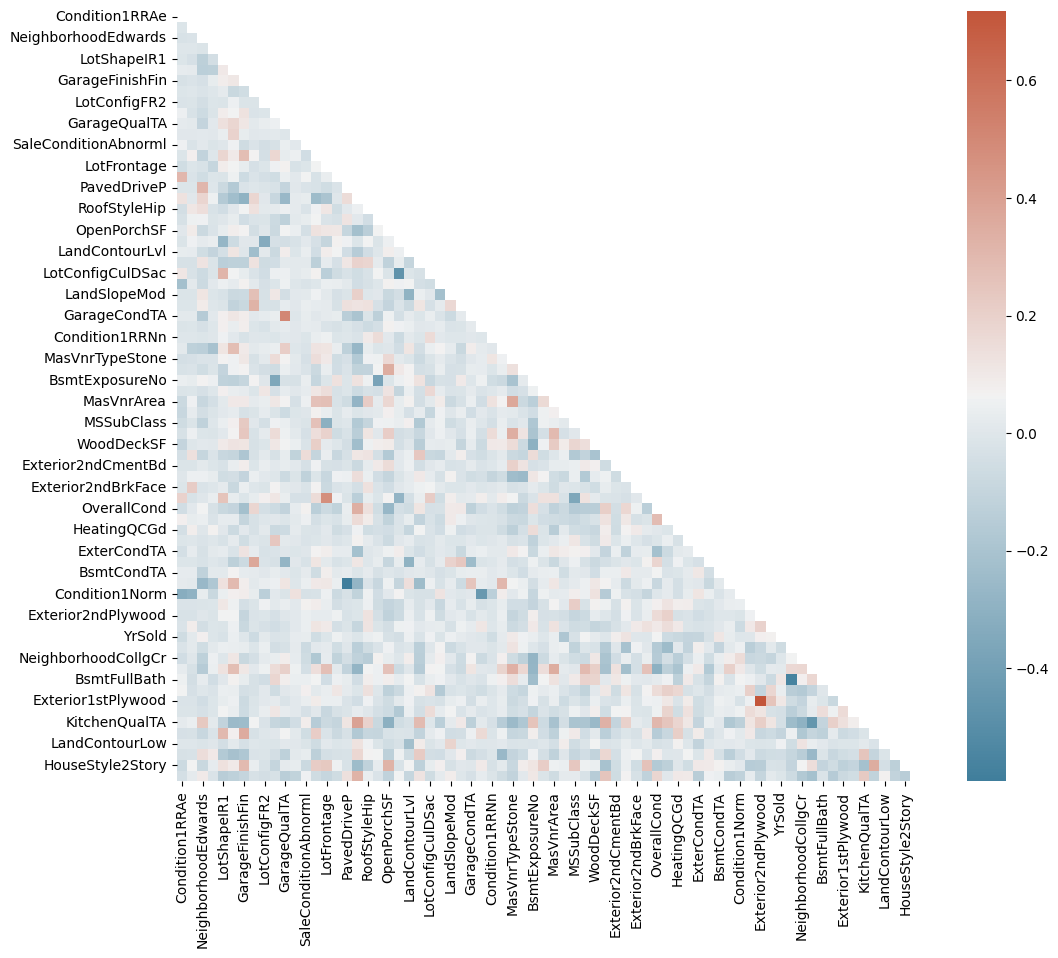

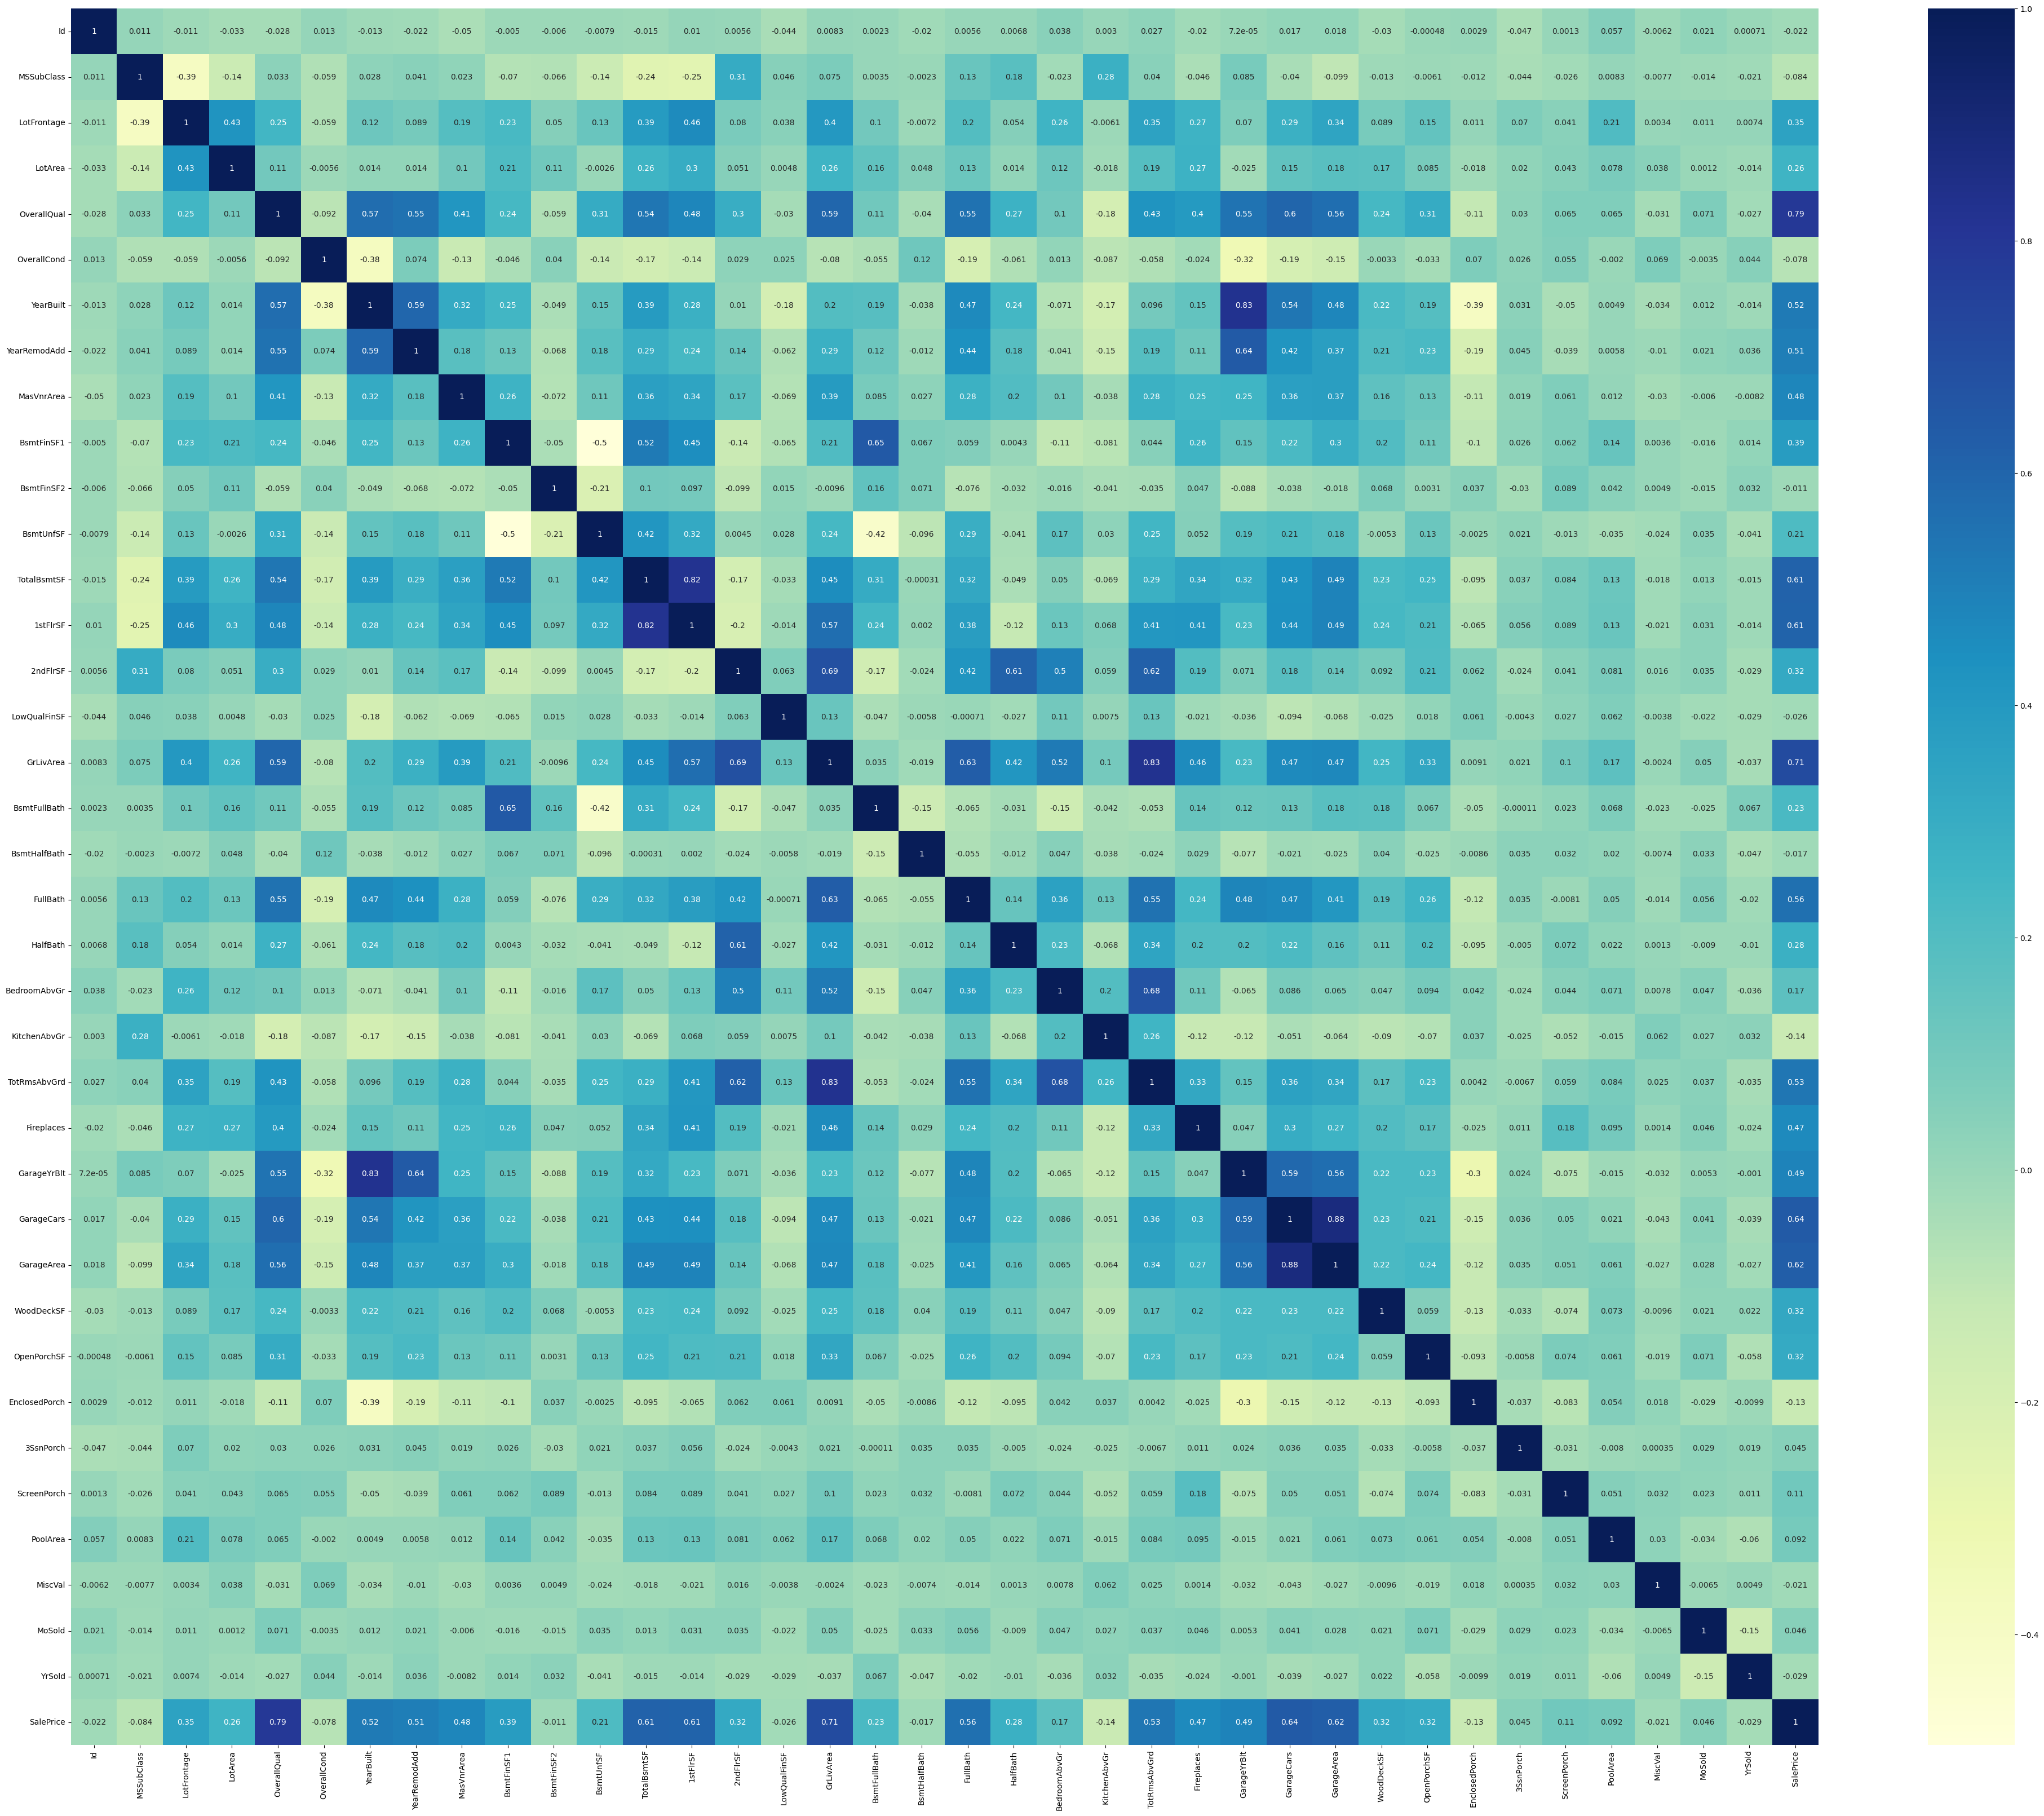

In [43]:
corr = dataFeatures[columns].corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap)

plt.figure(figsize=(50,40))
sns.heatmap(data.corr(),cmap='YlGnBu',annot=True)

### Training the Model

In [13]:
y = dataFeatures['SalePrice']
x = dataFeatures[columns]
reg = LinearRegression()
reg.fit(x, y)


LinearRegression()

### Displaying Intercept and Coefficients

In [14]:
print("Intercept:", reg.intercept_)
print("Coefficients:", reg.coef_)

Intercept: -566917.8580690894
Coefficients: [-1.57711414e+04  1.32971812e+04 -2.67501451e+04  5.21445057e+03
 -2.39607583e+03  2.93856461e+03  3.12080992e+03 -5.32503660e+04
 -8.94714751e+03  1.20560786e+04  1.88673061e+04 -2.87203024e+04
 -5.64392258e+03  1.00729126e+04  9.82912962e+01 -6.17545122e+03
  8.98969107e+03 -1.20285265e+04  3.89001815e+03  2.27162374e+03
  1.39588993e+02  9.80415896e+02 -2.71854062e+03 -9.17949758e+03
  1.37339396e+04  2.02702194e+03  3.16750482e+03  2.34743133e+04
  8.93240293e+03  8.45627875e+03 -2.03708706e+03  1.15154948e+04
  1.22058974e+04 -1.88631613e+03 -3.06491910e+03  1.79400780e+04
  2.65323975e+01  2.14121302e+02 -3.38942045e+01  4.25261561e+04
  3.08037356e+01 -2.00278063e+04  2.29757066e+04 -4.99318903e+03
  1.33939104e+04  2.84232810e+00  1.10509814e+03 -4.87501234e+03
 -2.52204486e+03 -3.14075611e+04  5.90141701e+03  3.34160814e+04
  6.56613036e+03  6.17328835e+03  1.67158704e+04 -3.32221216e+03
 -1.14442408e+04 -1.03347382e+04  3.04093258e+

### Value Prediction for testing values

In [35]:
x_test = testingFeatures[columns]
y_forTest = reg.predict(x_test)
y_forTest

array([156910.95597128, 196095.1155866 , 290000.        , 257465.65795365,
       215930.43833661, 117729.54611827, 157929.09774169, 112788.30773603,
       203056.6342366 , 201607.59668333, 205403.97562943, 196841.90837206,
       186651.49273272, 190876.08984555, 163396.10665655, 129969.74775075,
       168945.27357892, 236784.27544071, 177159.52202618, 133799.07461602,
       213086.2615363 , 167419.39661206, 224112.67426623, 190805.78921758,
       223773.63588556, 185306.17394746, 192574.78071109, 202935.3398293 ,
       227990.45535069, 196990.8027346 , 184096.70610627, 214848.55829687,
       166765.49429272, 199349.77392345, 207672.18751235,  97551.44422994,
       173946.35026734])

### RMSE value for the training dataset of price prediction

In [36]:

y_pred = reg.predict(x)
rmse = math.sqrt(mean_squared_error(y, y_pred))
print("RMSE:", rmse)

RMSE: 23494.364349139858


### R Square Score for Multiple Regression


In [38]:
r_square = reg.score(x, y)
print("R-Square:", r_square)



R-Square: 0.8444619024729351


### Predicted vs Actual Graph

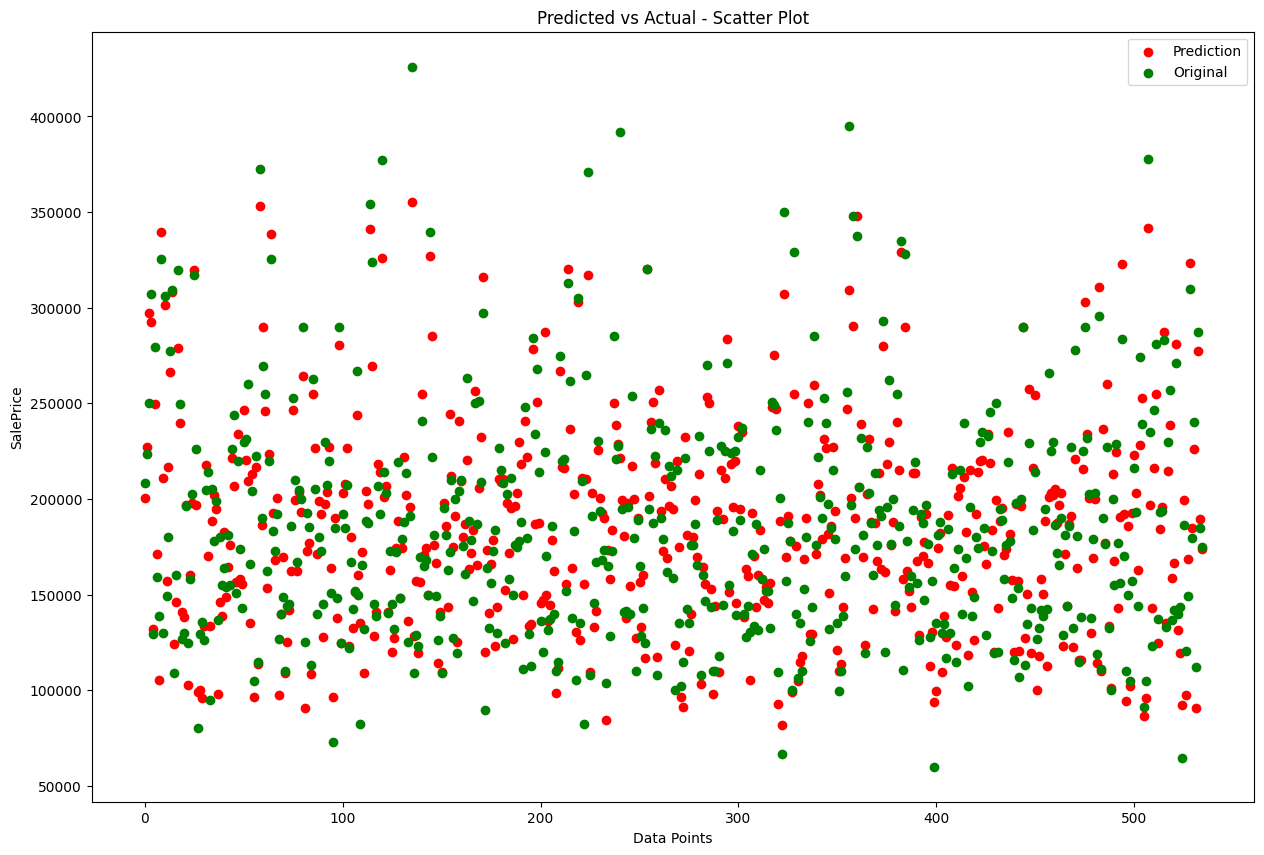

In [18]:
# Scatter Plot
plt.figure(figsize=(15, 10))
plt.scatter(range(len(y_pred)), y_pred, c='r', label='Prediction')
plt.scatter(range(len(y)), y, c='g', label='Original')
plt.legend()
plt.title("Predicted vs Actual - Scatter Plot")
plt.xlabel("Data Points")
plt.ylabel("SalePrice")
plt.show()

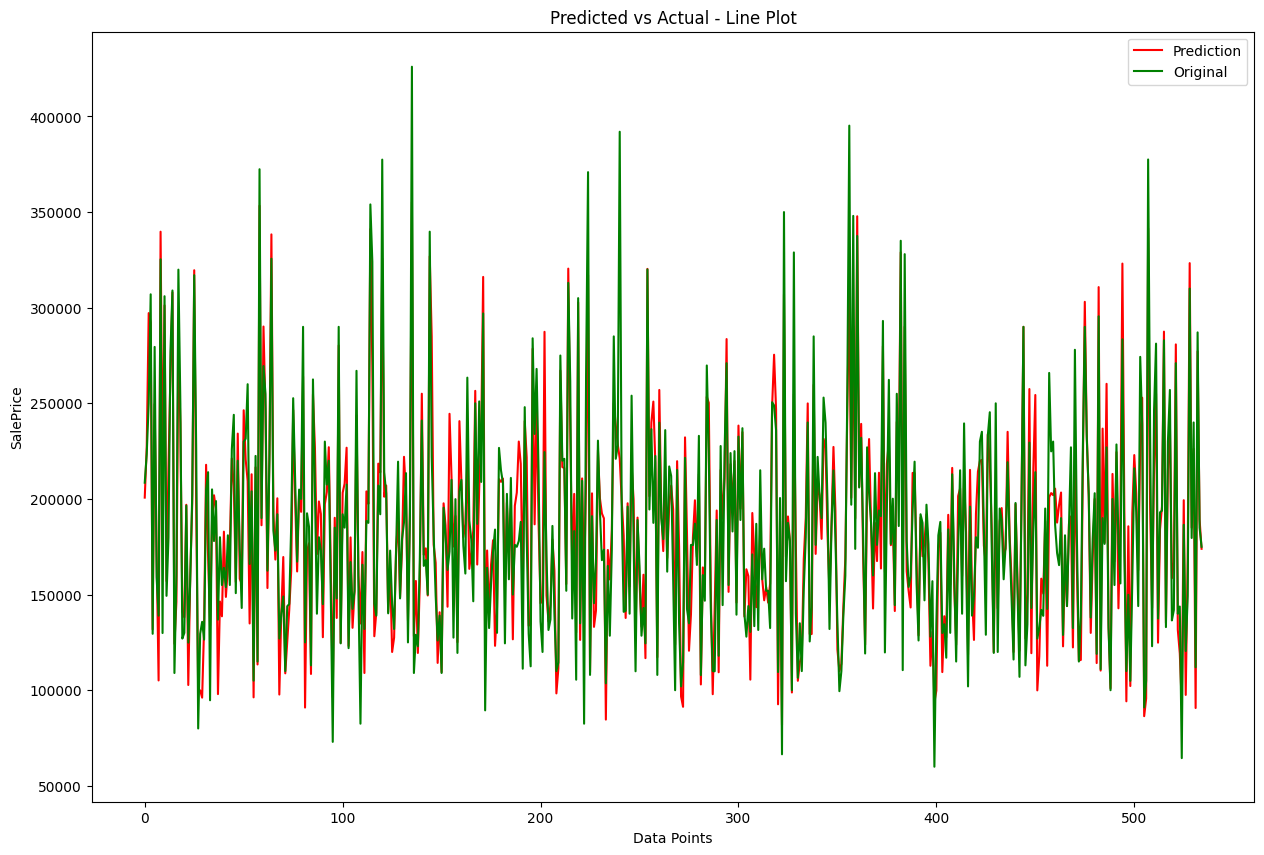

In [19]:
# Line Plot
plt.figure(figsize=(15, 10))
plt.plot(y_pred, c='r', label='Prediction')
plt.plot(y.values, c='g', label='Original')
plt.legend()
plt.title("Predicted vs Actual - Line Plot")
plt.xlabel("Data Points")
plt.ylabel("SalePrice")
plt.show()